## Importar librerias

In [1]:
import cv2
import math
import random
from moviepy.editor import *
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
import pathlib
import IPython.display as display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical, plot_model
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers, Sequential, Input
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K 

2022-07-08 13:21:12.918139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moises/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-07-08 13:21:12.918199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Parametros

In [3]:
# Cantidad de Epocas para el entrenamiento
epochs = 50
# Especificar la resolucion de la imágenes del dataset
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Especificar el número de Frames que representan el video
SEQUENCE_LENGTH = 10

# Especificar el directorio de la base de datos
DATASET_DIR = './dataset/full'

# Especificar la lista de clases, en este caso la Ñ la reemplaza por NE para que no creara conflicto con el codigo
CLASSES_LIST = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "NE", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

# Especificar el Loss_rate y el momentum para el entrenamiento del modelo
lr = 0.001
momentum = 0.9

## Cargar Imagenes y Pre-Procesamiento

In [4]:
def frames_extraction(video_path):
    '''
    Esta función recupera las imagenes desde la base de datos las redimensiona a la resolucion especificada en parametros y las normaliza.
    Args:
        video_path: Ruta de la imagen en el directorio.
    Returns:
        frames_list: Una lista con los frames separados en el intervalo especificado en parámetros.
    '''

    # Declarar las variables
    frames_list = []
    
    frame_counter = 1

    # hacer una iteración para guardar los frames en el intervalo especificado
    for frame_counter in range(SEQUENCE_LENGTH):

        # Leer la imagen desde el directorio
        frame = cv2.imread(video_path) 

        # Redimensionar la imagen
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalizar la imagen entre 0 y 1
        normalized_frame = resized_frame / 255
        
        # Agregar elementos a la lista de frames
        frames_list.append(normalized_frame)
        
        frame_counter += 1

    # Retorna la frames list.
    return frames_list

In [5]:
def create_dataset():
    '''
    En esta funcion se va crear la base de datos con los frames extraidos del directorio.
    Returns:
        features:          Una lista con los frames extraidos.
        labels:            Una lista con las clases asociadas a cada imagen.
        video_files_paths: Una lista con el directorio donde están contenidas las imagenes.
    '''

    # Declarar las listas vacias para cada variable
    features = []
    labels = []
    video_files_paths = []
    
    # Se va a iterar sobre cada clase
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Para poder mostrar en que parte de la extracción va el codigo
        print(f'Extracting Data of Class: {class_name}')
        
        # Se crea la ruta de directorio con el nombre de cada clase 
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Se hace una iteración en la que se extraigan los frames pertenecientes a la clase
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            # Llamado de la funcion de extraccion
            frames = frames_extraction(video_file_path)

            # Revisar si los frames son iguales al parametro de tiempo
            if len(frames) == SEQUENCE_LENGTH:

                # Agregar la informacion a sus listas
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # convertir las listas a arreglos de numpy
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Retorna los frames, las clases y la ruta de archivos
    return features, labels, video_files_paths
            

In [6]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: A
Extracting Data of Class: B
Extracting Data of Class: C
Extracting Data of Class: D
Extracting Data of Class: E
Extracting Data of Class: F
Extracting Data of Class: G
Extracting Data of Class: H
Extracting Data of Class: I
Extracting Data of Class: J
Extracting Data of Class: K
Extracting Data of Class: L
Extracting Data of Class: M
Extracting Data of Class: N
Extracting Data of Class: NE
Extracting Data of Class: O
Extracting Data of Class: P
Extracting Data of Class: Q
Extracting Data of Class: R
Extracting Data of Class: S
Extracting Data of Class: T
Extracting Data of Class: U
Extracting Data of Class: V
Extracting Data of Class: W
Extracting Data of Class: X
Extracting Data of Class: Y
Extracting Data of Class: Z


In [7]:
one_hot_encoded_labels = to_categorical(labels)

In [8]:
# Se separa el dataset para el entrenamiento en 80% y validacion del 20%
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [6]:
K.clear_session()

## Creacion del Modelo, Heredando de MobileNet_v2

In [7]:
inp = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT , IMAGE_WIDTH, 3))

cnn = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT , IMAGE_WIDTH, 3))

for layer in cnn.layers[:-30]:
	layer.trainable = False

headModel = TimeDistributed(cnn)(inp)

headModel = TimeDistributed(GlobalAveragePooling2D())(headModel)
headModel = Dense(256, activation="relu")(headModel)

headModel = TimeDistributed(Flatten())(headModel)

headModel = TimeDistributed(Dropout(0.5))(headModel)

headModel = LSTM(16)(headModel)
headModel = Dense(len(CLASSES_LIST), activation="softmax")(headModel)

model = Model(inputs=inp, outputs=headModel)


2022-07-08 13:21:37.700490: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-08 13:21:37.700621: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Asus-TUF): /proc/driver/nvidia/version does not exist
2022-07-08 13:21:37.702809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9406464/9406464 [==============================] - 1s 0us/step


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 10, 2, 2, 1280)   2257984   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 1280)         0         
 tributed)                                                       
                                                                 
 dense (Dense)               (None, 10, 256)           327936    
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 256)          0         
 tributed)                                                       
                                                             

## Entrenamiento del Modelo

In [9]:
model.compile(
      optimizer=optimizers.SGD(lr, momentum), 
      #optimizer=optimizers.Adam(learning_rate=0.001),
      loss = 'categorical_crossentropy', 
      metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

early_stopper = EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

model.load_weights('CNN_LSTM_10_64_64_v1.h5')

#history = model.fit(x = features_train,
#                    y = labels_train,
#                    epochs=epochs,
#                    validation_data = [features_test, labels_test],
#                    callbacks=[early_stopper, reduce_lr])

In [13]:
model.save("CNN_LSTM_10_64_64_v1.h5")
print('ok')

ok


## Graficar precisión y perdida

In [14]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

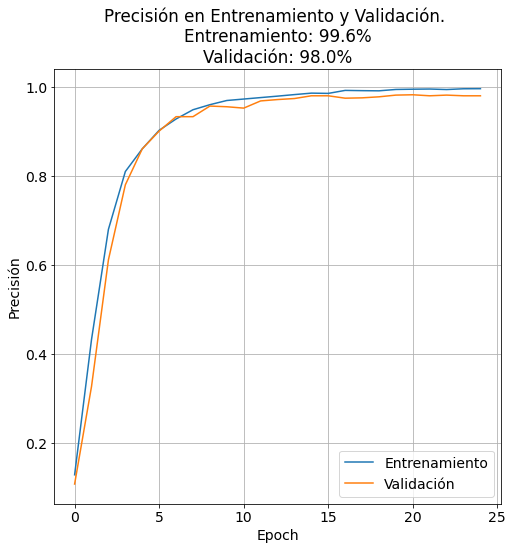

In [17]:
#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.plot(acc, label='Entrenamiento')
plt.plot(val_acc, label='Validación')
plt.legend(loc='lower right')
plt.ylabel('Precisión')
plt.xlabel('Epoch')
plt.title(f'Precisión en Entrenamiento y Validación. \nEntrenamiento: {str(round(acc[-1],4)*100)}%\nValidación: {str(round(val_acc[-1],3)*100)}%')
plt.savefig('CNN_LSTM_V2_Acc')

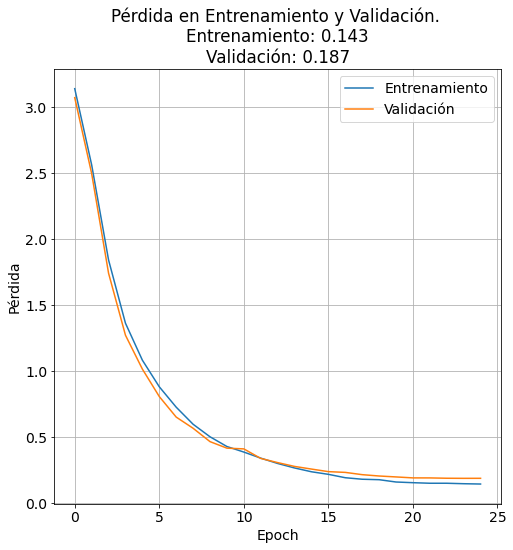

In [16]:
#loss
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.legend(loc='upper right')
plt.ylabel('Pérdida')
plt.title(f'Pérdida en Entrenamiento y Validación. \nEntrenamiento: {str(round(loss[-1],3))}\nValidación: {str(round(val_loss[-1],3))}')
plt.xlabel('Epoch')
plt.savefig('CNN_LSTM_V2_Loss')

In [11]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
 
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Read a frame.
        success, frame = video_reader.read() 
 
        # Check if frame is not read properly then break the loop.
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()

In [17]:
# Construct tihe nput youtube video path
input_video_file_path = f'/home/moises/Documentos/videos/S/S1.mp4'
 
# Perform Single Prediction on the Test Video.
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)
 
# Display the input video.
VideoFileClip(input_video_file_path, audio=False, target_resolution=(None,None)).ipython_display()

1/1 [==============================] - 0s 37ms/step
Action Predicted: S
Confidence: 0.8798453211784363
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
